In [1]:
from simulate import *

from datetime import datetime
from os import getcwd, makedirs, path
from shutil import copyfile
from time import time
from PIL import Image

from IPython.display import HTML


# Image preprocessing
binary_threshold = 10

# Connected components
connection_radius = 2

# Latice and region creation
lattice_radius = 25
lattice_stride = 25
min_component_size = 2

# Simulation
num_free_cells = 300
neighborhood_radius = 2
max_iterations = 10
num_simulations = 100

# Meta
verbose = True

# Standard green image with diagonal vessel
# image = Image.open("images/binary.jpg")

# Fork in the road
# image = Image.open("images/Art-2-vessels-binarized.tif")

# Large vessel in the middle, capilaries on both sides
image = Image.open("images/Art-8-vessels-blackandwhite 20x.tif")

# Very capiliary-y
# image = Image.open("images/Cap-2-binarized.tif")

%matplotlib inline
%load_ext autoreload
%autoreload 2
%precision 3

'%.3f'

In [2]:
new_dirname = path.join(getcwd(), datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
makedirs(new_dirname)

# Copy the configuration file to the directory so that we can see
# the values that generated the outputs
copyfile("./configuration.py", path.join(new_dirname, "configuration.py"))

# Force the image to be square
# TODO: ask Ryan if we can expect most images to be about 512x512
square_image = image.resize((512, 512))

start = time()
binary_image = binarize_and_threshold_image(square_image, binary_threshold)
if verbose:
    print(binary_image.shape, binary_image.dtype)
    print(f"Time to binarize the input image: {time() - start:0.3f}s\n")

start = time()
adj_list = create_matrix_from_adjacency_list(binary_image, connection_radius)
if verbose:
    print("Number of vertices in graph:", len(adj_list))
    print(f"Time to create graph: {time() - start:0.3f}s\n")

start = time()
components = find_connected_compnents(adj_list)
num_components = len(components)
if verbose:
    print("Number of components:", num_components)
    print(f"Time to compute connected components: {time() - start:0.3f}s\n")

start = time()
lattice = count_components_per_region(
    binary_image.shape,
    lattice_radius,
    lattice_stride,
    components,
    min_component_size,
)
if verbose:
    print(f"Time to create regions: {time() - start:0.3f}s\n")

start = time()
brightness = compute_brightness_per_region(square_image, lattice_stride)
regions = compute_region_push_pull_score(lattice, brightness)
if verbose:
    print(f"Time to create regions: {time() - start:0.3f}s\n")

(512, 512) uint8
Time to binarize the input image: 0.002s

Number of vertices in graph: 262144
Time to create graph: 19.382s

Number of components: 53
Time to compute connected components: 0.988s

Time to create regions: 1.878s

Time to create regions: 0.006s



In [3]:
start = time()
final_panes, animation_data = run_animations(
    regions,
    neighborhood_radius,
    max_iterations,
    num_simulations,
    num_free_cells,
)
if verbose:
    print(f"Time to run animations: {time() - start:0.3f}s\n")

Time to run animations: 26.930s



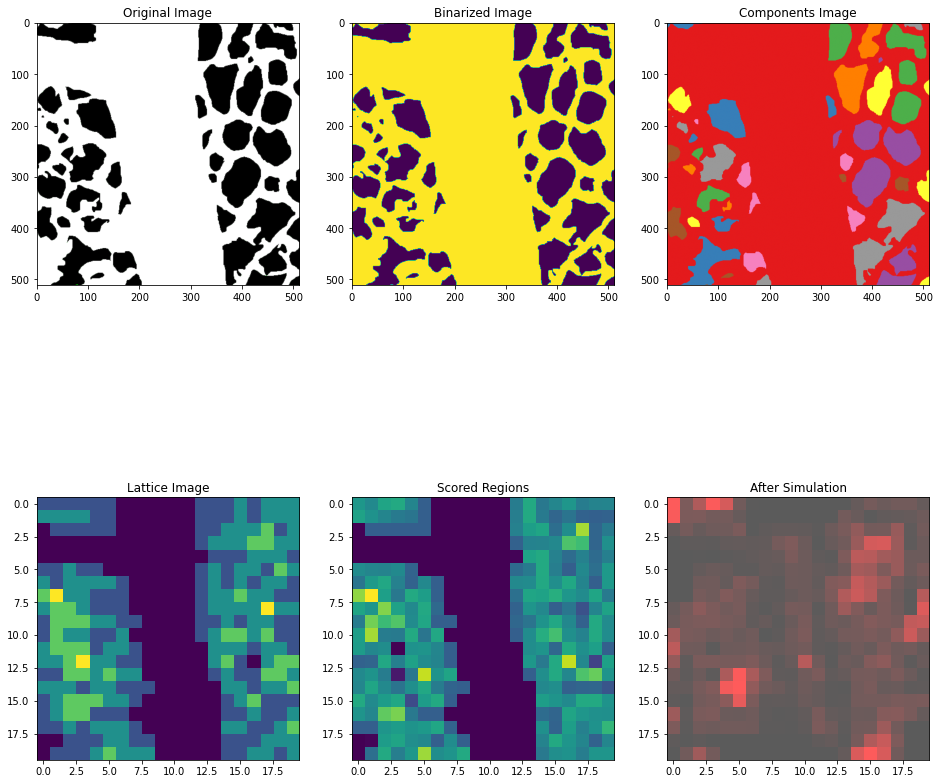

In [4]:
plot_figures(
    components,
    square_image,
    final_panes,
    binary_image,
    lattice,
    regions,
    new_dirname,
)

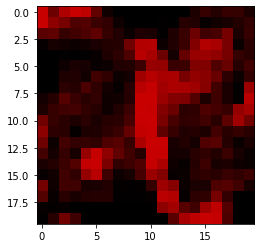

In [5]:
animation = generate_animation_image(animation_data, new_dirname);

In [6]:
HTML(animation.to_jshtml())

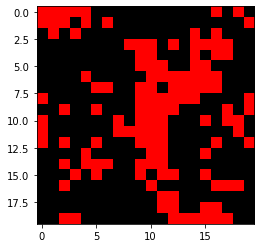

In [7]:
# Single animation
animation = generate_animation_image([animation_data[0]], new_dirname);

In [8]:
HTML(animation.to_jshtml())

In [9]:
# Playing with travel function
grid, animation = animate_cells(num_free_cells, regions, max_iterations, neighborhood_radius)

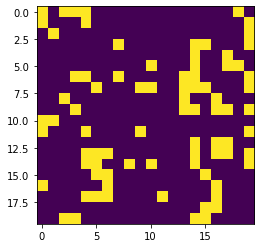

In [10]:
plt.imshow(grid);

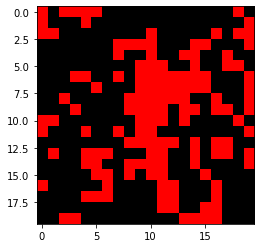

In [11]:
animation = generate_animation_image([animation], new_dirname);
HTML(animation.to_jshtml())